In [1]:
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datasets import load_dataset,concatenate_datasets
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
def filter_data(data, metric_name, metric_value):    
    if metric_name == 'degree':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['min_angle']<=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['min_angle']>metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['min_angle']>metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['min_angle']<=metric_value)))
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])        
    elif metric_name == 'area':
        p_id = data.filter(lambda x: ((x['label']==1) & (x['max_area']>=metric_value)))
        p_ood = data.filter(lambda x: ((x['label']==1) & (x['max_area']<metric_value)))        
        n_id = data.filter(lambda x: ((x['label']==0) & (x['max_area']<metric_value)))
        n_ood = data.filter(lambda x: ((x['label']==0) & (x['max_area']>=metric_value)))        
        id_data=concatenate_datasets([p_id,n_id])
        ood_data=concatenate_datasets([p_ood,n_ood])    
    return id_data, ood_data

In [3]:
def metric_calculation(data):
    gt=data['label']
    pred=data['pred']
    acc=accuracy_score(gt, pred)
    _,fpc,fnc,_=confusion_matrix(gt, pred).ravel()
    fpr=fpc/len(data)
    fnr=fnc/len(data)
    return acc,fpr,fnr

In [4]:
def post_processing(data, model, metric_name, metric_value):
    
    ## load ground truth & predictions
    gt=np.array(data['label'])
    if model == 'heuristic':
        if metric_name=='degree':
            pred=np.array(data['min_angle'])<=metric_value
        elif metric_name == 'area':
            pred=np.array(data['max_area'])>=metric_value
    elif model == 'bert':
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')        
    else:
        pred=np.load(f'{metric_name}/{model}_{metric_name}_{metric_value}.npy')
        pred=np.array([int(i.replace('<|eot_id|>', '')\
                           .replace('</s>', '')\
                           .split('Label:')[1]\
                           .strip()) for i in pred])
    data=data.add_column("pred", pred)
    id_data, ood_data=filter_data(data, metric_name, metric_value)
    
    return data,id_data,ood_data

In [5]:
ds = load_dataset("beanham/spatial_union_dataset")
test=ds['test']

In [7]:
metric_name='degree'
models=['heuristic','llama3','mistral','4o_mini','bert']
models=['heuristic','llama3', 'mistral', '4o_mini']
metric_values=[1,2,3,4,5]
results=[]
for model in models:
    for metric_value in metric_values:
        data,id_data,ood_data=post_processing(test,model,metric_name,metric_value)
        acc,fpr,fnr=metric_calculation(data)
        id_acc,_,_=metric_calculation(id_data)
        ood_acc,_,_=metric_calculation(ood_data)
        results.append([model, metric_name, metric_value, acc,fpr,fnr,len(id_data),id_acc,len(ood_data),ood_acc])
results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr','id_count','id_acc','ood_count','ood_acc'])
results['total_count']=[len(test)]*len(results)
results['id_correct_count']=results.id_count.values*results.id_acc.values
results['ood_correct_count']=results.ood_count.values*results.ood_acc.values

# Min_Angle

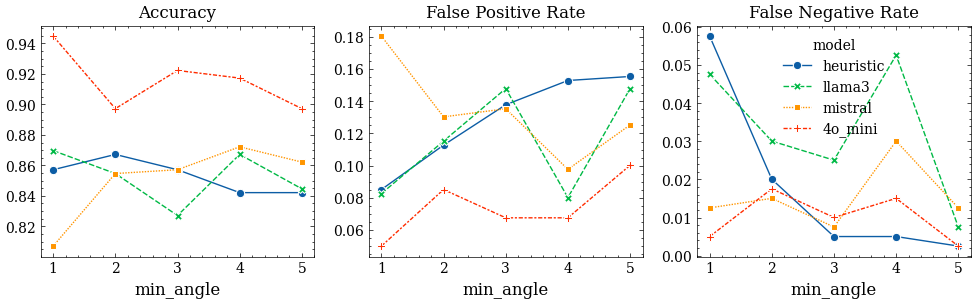

In [8]:
plt.style.use('science')
plt.rc('text', usetex=False)
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('min_angle', fontsize=12)
axs[1].set_xlabel('min_angle', fontsize=12)
axs[2].set_xlabel('min_angle', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
#plt.savefig(f"../../misc/min_angle_resuts.png", bbox_inches='tight',pad_inches=0, dpi=600)
pass

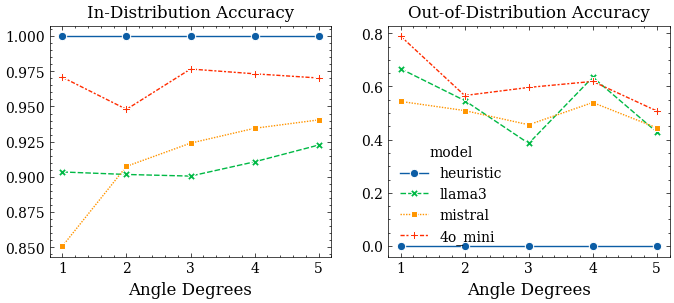

In [9]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Angle Degrees', fontsize=12)
axs[1].set_xlabel('Angle Degrees', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass

In [10]:
stack_methods=[]
stack_id_or_ood=[]
stack_values=[]
metric_name='degree'
models=['heuristic', 'llama3', 'mistral', '4o_mini']
metric_values=[1,2,3,4,5]
for model in models:
    for metric_value in metric_values:
        sub_results=results[(results.model==model) & (results.metric==metric_name) & (results.metric_value==metric_value)]            
        stack_methods+=[model]*len(test)            
        correct_ids=['Correct IDD']*int(sub_results.id_correct_count.values[0])
        wrong_ids=['Wrong IDD']*int(sub_results.id_count.values[0]-len(correct_ids))
        correct_oods=['Correct ODD']*int(sub_results.ood_correct_count.values[0])
        wrong_oods=['Wrong ODD']*int(sub_results.ood_count.values[0]-len(correct_oods))
        all_ids=correct_ids+wrong_ids+correct_oods+wrong_oods
        stack_id_or_ood+=all_ids                    
        stack_values+=[metric_value]*len(test)            
stack_vis=pd.DataFrame(np.c_[stack_methods, stack_id_or_ood, stack_values],columns=['method','distribution','metric'])
correct_ids=stack_vis[stack_vis.distribution=='Correct IDD']
wrong_ids=stack_vis[stack_vis.distribution=='Wrong IDD']
correct_oods=stack_vis[stack_vis.distribution=='Correct ODD']
wrong_oods=stack_vis[stack_vis.distribution=='Wrong ODD']
degree_vis=pd.concat([correct_ids, wrong_ids, correct_oods, wrong_oods])

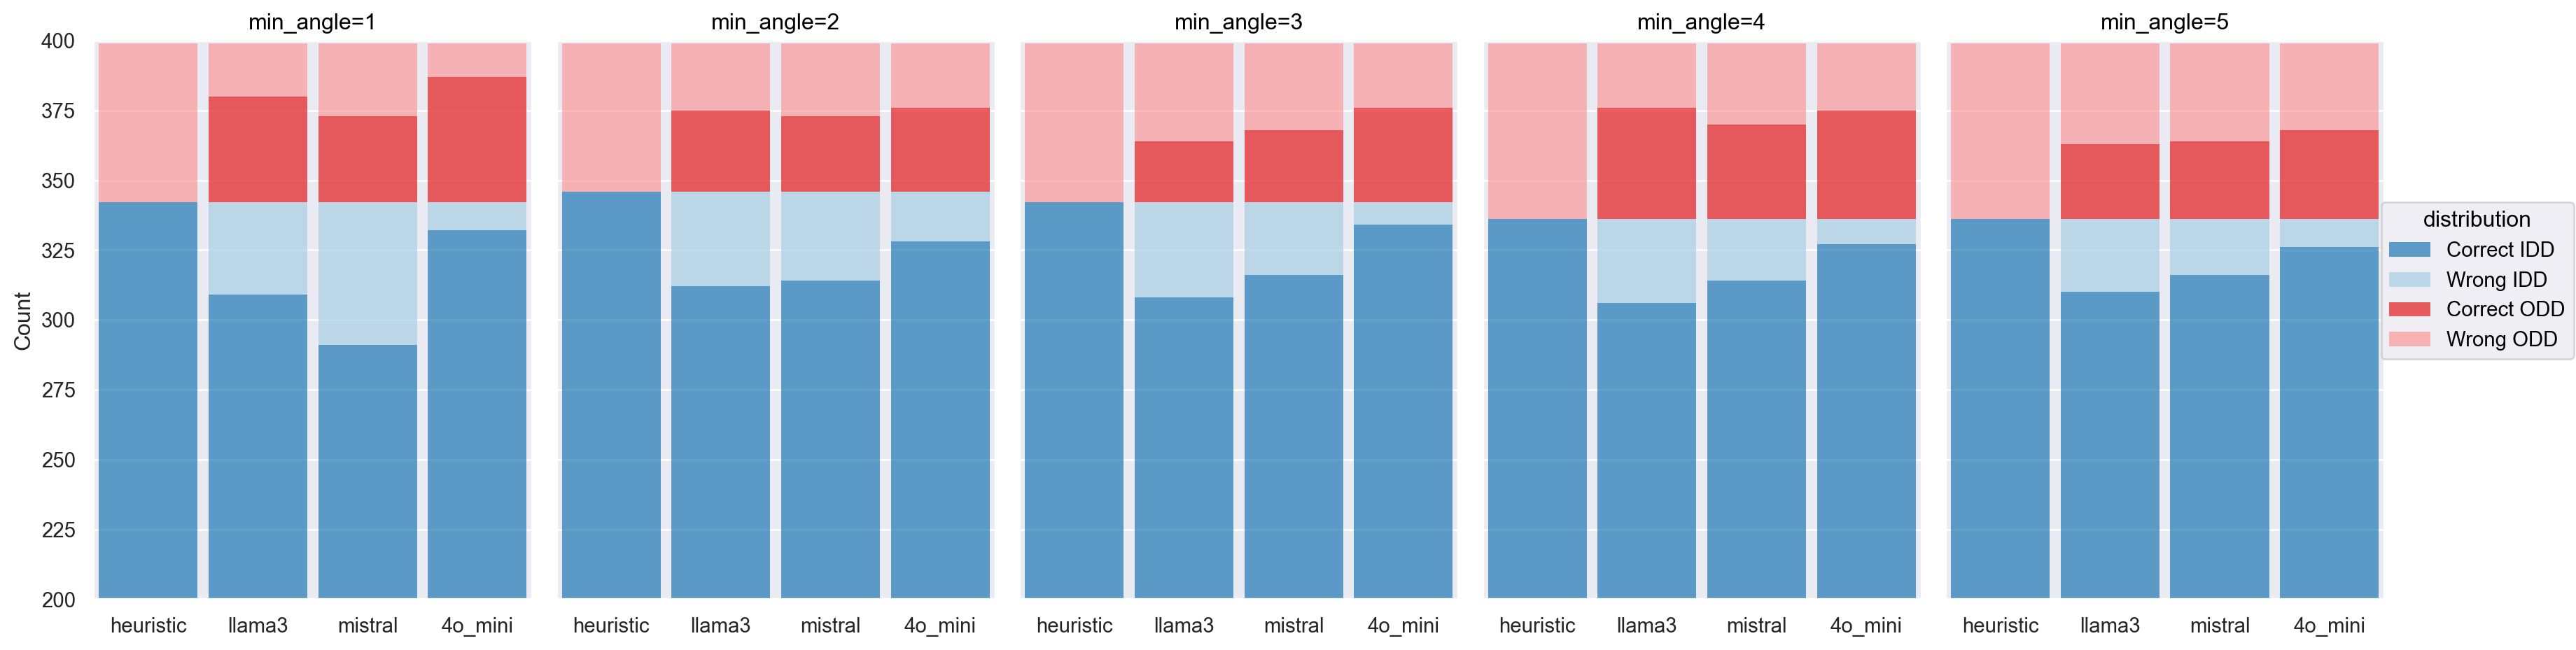

In [11]:
palette=list(sns.color_palette("Paired"))
(
    so.Plot(degree_vis, x="method", color="distribution",)
    .layout(size=(18, 5))
    .add(
        so.Bar(edgealpha=0,width=0.9),
        so.Count(),
        so.Stack()
    )
    .scale(color=[palette[1],palette[0],palette[5],palette[4]])
    .facet("metric")
    .limit(y=(200, 400))
    .label(
        y="Count",
        x="",
        title="min_angle={}".format
    )
)
#plot.save(f"../../misc/min_angle_generalization_resuts.png", format='png',  bbox_inches='tight',pad_inches=0, dpi=600)

# Distance

In [27]:
models=['heuristic','llama3','mistral', '4o_mini', 'bert']
metric_name='area'
models=['heuristic','llama3']
metric_values=[0.5,0.6,0.7,0.8,0.9]
results=[]
for model in models:
    for metric_value in metric_values:
        data,id_data,ood_data=post_processing(test,model,metric_name,metric_value)
        acc,fpr,fnr=metric_calculation(data)
        id_acc,_,_=metric_calculation(id_data)
        ood_acc,_,_=metric_calculation(ood_data)
        results.append([model, metric_name, metric_value, acc,fpr,fnr,len(id_data),id_acc,len(ood_data),ood_acc])
results=pd.DataFrame(results, columns=['model','metric','metric_value','acc','fpr','fnr','id_count','id_acc','ood_count','ood_acc'])
results['total_count']=[len(test)]*len(results)
results['id_correct_count']=results.id_count.values*results.id_acc.values
results['ood_correct_count']=results.ood_count.values*results.ood_acc.values

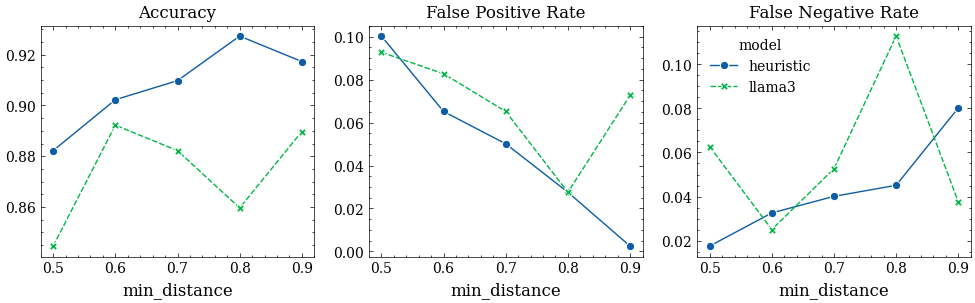

In [28]:
fig, axs = plt.subplots(ncols=3,figsize=(12, 3))
sns.lineplot(data=results, x="metric_value", y="acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="fpr",style="model",hue="model",markers=True,ax=axs[1],legend=False)
sns.lineplot(data=results, x="metric_value", y="fnr",style="model",hue="model",markers=True,ax=axs[2])
axs[0].set_xlabel('min_distance', fontsize=12)
axs[1].set_xlabel('min_distance', fontsize=12)
axs[2].set_xlabel('min_distance', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_title('Accuracy', fontsize=12)
axs[1].set_title('False Positive Rate', fontsize=12)
axs[2].set_title('False Negative Rate', fontsize=12)
#plt.savefig(f"../../misc/min_distance_resuts.png", bbox_inches='tight',pad_inches=0, dpi=600)
pass

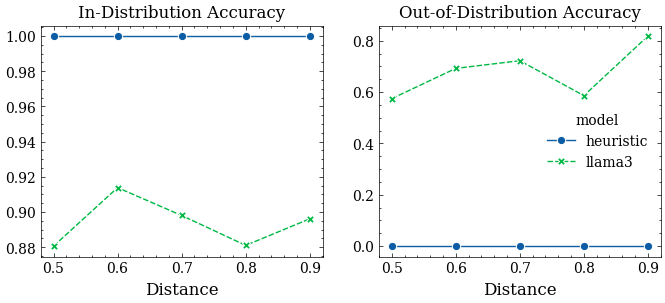

In [29]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 3))
sns.lineplot(data=results, x="metric_value", y="id_acc",style="model",hue="model",markers=True,ax=axs[0],legend=False)
sns.lineplot(data=results, x="metric_value", y="ood_acc",style="model",hue="model",markers=True,ax=axs[1])
axs[0].set_xlabel('Distance', fontsize=12)
axs[1].set_xlabel('Distance', fontsize=12)
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_title('In-Distribution Accuracy', fontsize=12)
axs[1].set_title('Out-of-Distribution Accuracy', fontsize=12)
pass

In [30]:
stack_methods=[]
stack_id_or_ood=[]
stack_values=[]
models=['heuristic', 'llama3', 'mistral', '4o_mini', 'bert']
models=['heuristic', 'llama3']
metric_name='area'
metric_values=[0.5,0.6,0.7,0.8,0.9]
for model in models:       
    for metric_value in metric_values:
        sub_results=results[(results.model==model) & (results.metric==metric_name) & (results.metric_value==metric_value)]            
        stack_methods+=[model]*len(test)            
        correct_ids=['Correct IDD']*int(sub_results.id_correct_count.values[0])
        wrong_ids=['Wrong IDD']*int(sub_results.id_count.values[0]-len(correct_ids))
        correct_oods=['Correct ODD']*int(sub_results.ood_correct_count.values[0])
        wrong_oods=['Wrong ODD']*int(sub_results.ood_count.values[0]-len(correct_oods))
        all_ids=correct_ids+wrong_ids+correct_oods+wrong_oods
        stack_id_or_ood+=all_ids                    
        stack_values+=[metric_value]*len(test)            
stack_vis=pd.DataFrame(np.c_[stack_methods, stack_id_or_ood, stack_values],columns=['method','distribution','metric'])
correct_ids=stack_vis[stack_vis.distribution=='Correct IDD']
wrong_ids=stack_vis[stack_vis.distribution=='Wrong IDD']
correct_oods=stack_vis[stack_vis.distribution=='Correct ODD']
wrong_oods=stack_vis[stack_vis.distribution=='Wrong ODD']
distance_vis=pd.concat([correct_ids, wrong_ids, correct_oods, wrong_oods])

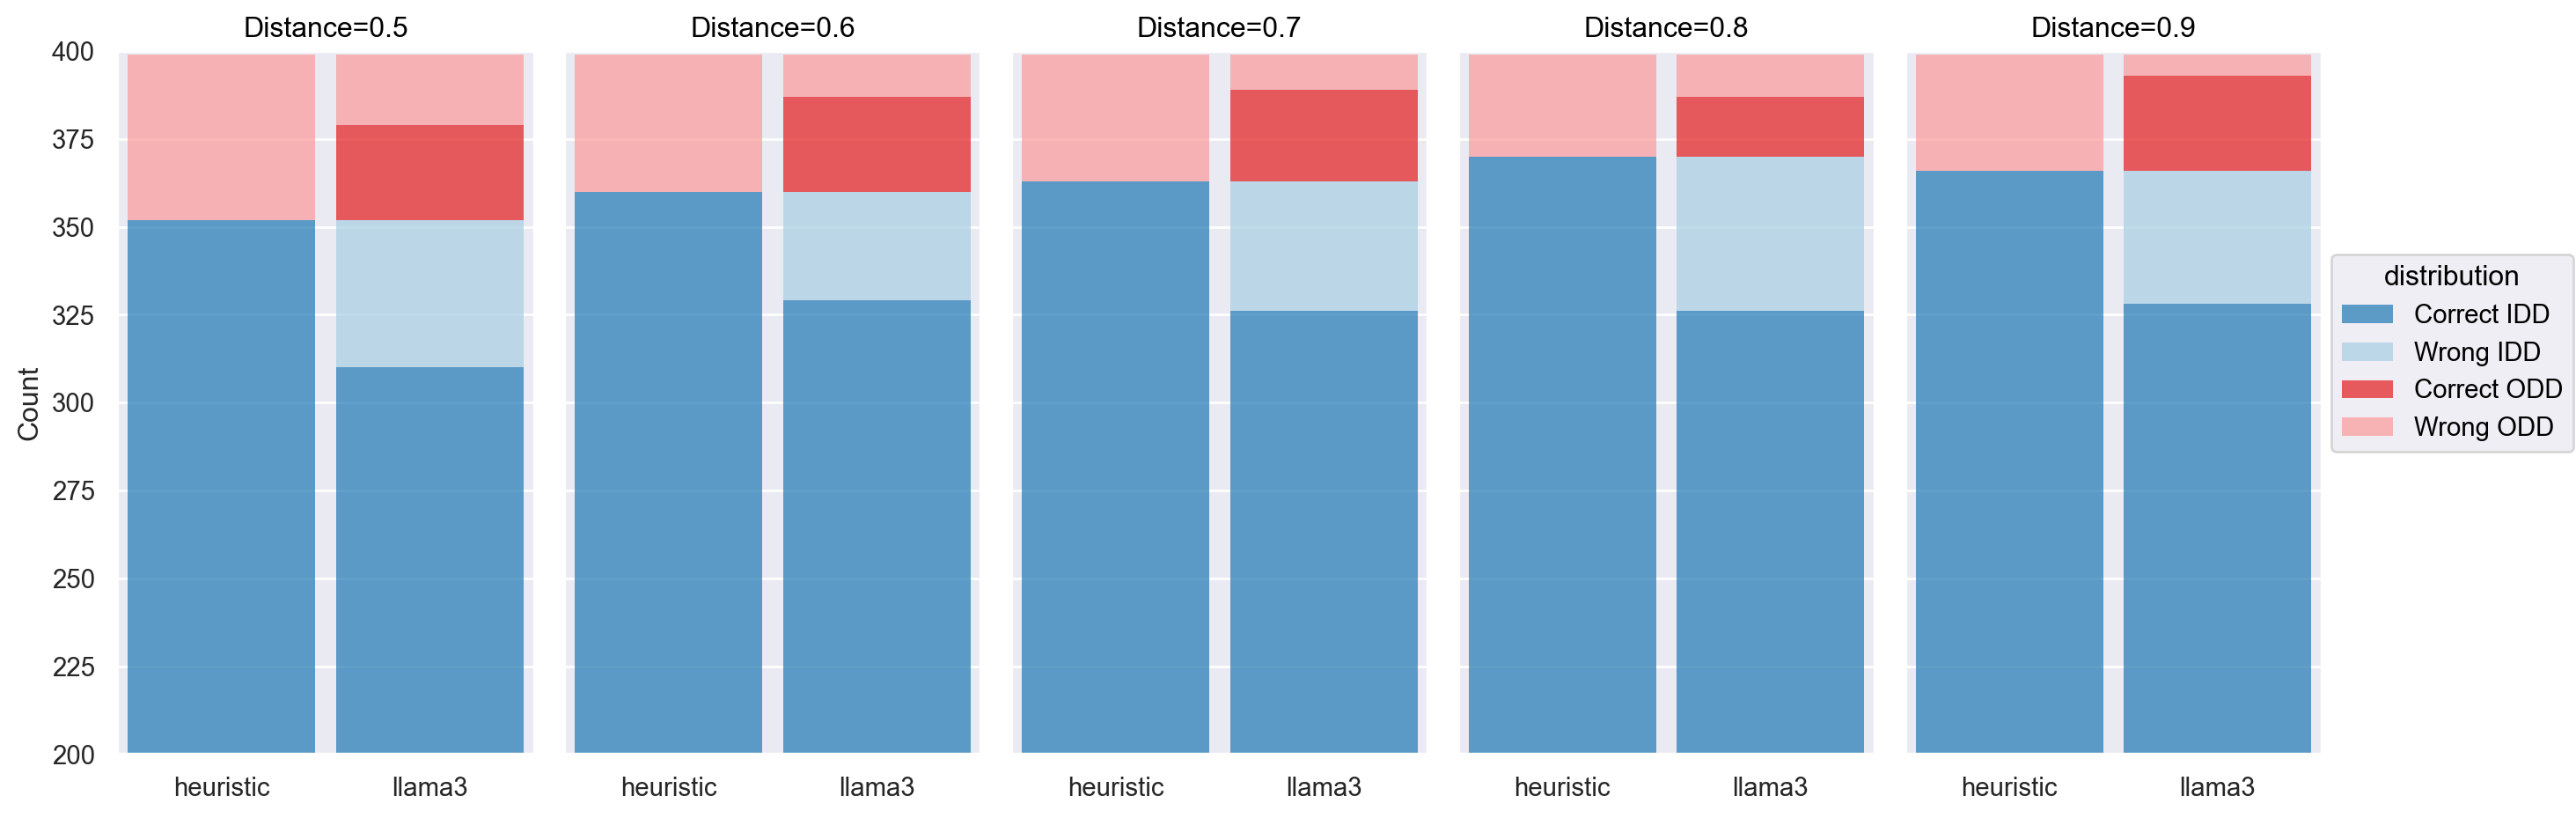

In [31]:
palette=list(sns.color_palette("Paired"))
(
    so.Plot(distance_vis, x="method", color="distribution",)
    .layout(size=(14, 5))
    .add(
        so.Bar(edgealpha=0,width=0.9),
        so.Count(),
        so.Stack()
    )
    .scale(color=[palette[1],palette[0],palette[5],palette[4]])
    .facet("metric")
    .limit(y=(200, 400))
    .label(
        y="Count",
        x="",
        title="Distance={}".format
    )
)

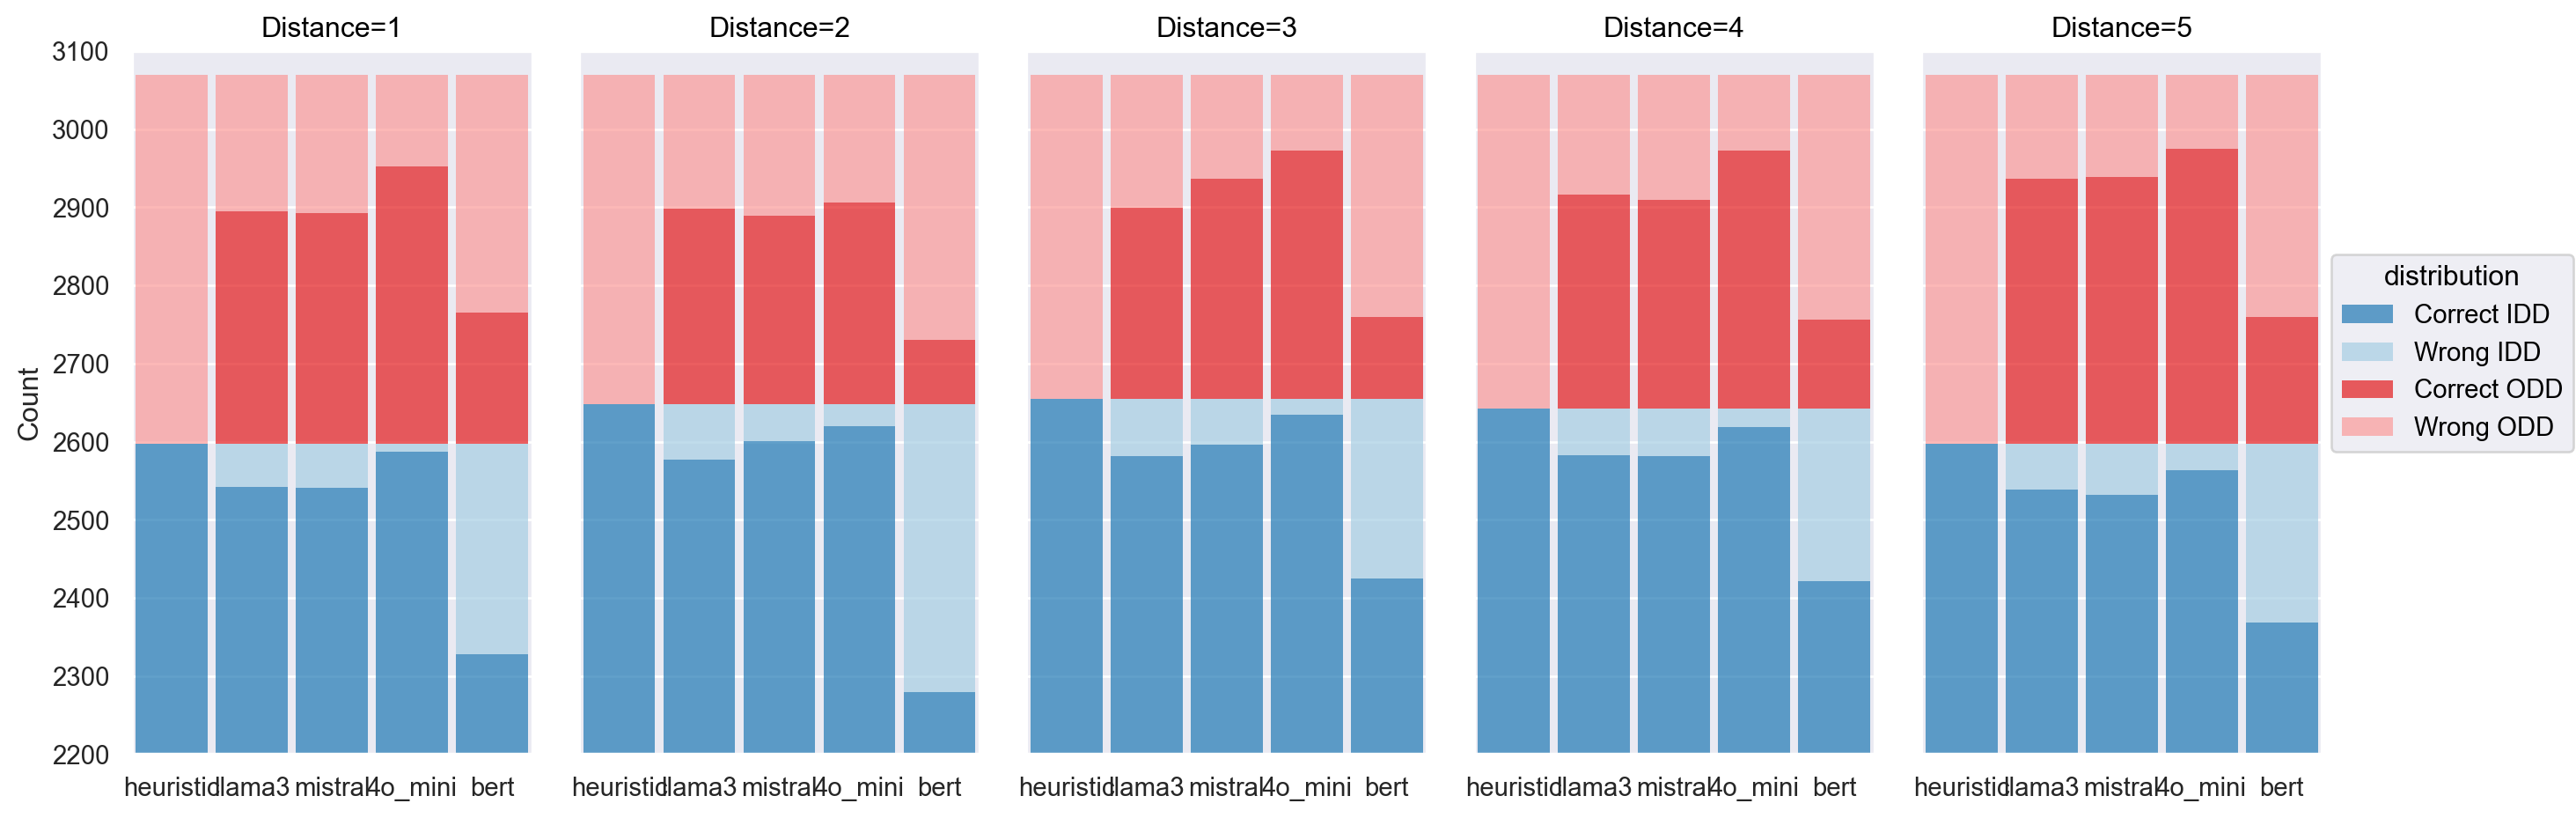

In [29]:
palette=list(sns.color_palette("Paired"))
plot=(
    so.Plot(distance_vis, x="method", color="distribution",)
    .layout(size=(14, 5))
    .add(
        so.Bar(edgealpha=0,width=0.9),
        so.Count(),
        so.Stack()
    )
    .scale(color=[palette[1],palette[0],palette[5],palette[4]])
    .facet("metric")
    .limit(y=(2200, 3100))
    .label(
        y="Count",
        x="",
        title="Distance={}".format
    )
)
plot.save(f"../../misc/min_distance_generalization_resuts.png", format='png',  bbox_inches='tight',pad_inches=0, dpi=600)